In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

tf.__version__

'2.1.0'

In [3]:
games_season = pd.read_csv('./games_season.csv')
games_tourney = pd.read_csv('./games_tourney.csv')

# Three-input models

## Make an input layer for home vs. away

In [4]:
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [5]:
# define team strength model

# count number of unique teams from df
n_teams = len(games_season['team_1'].unique())

# create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team_Strength')

# create input layer for team ID column
teamid_in = Input(shape=(1,))

# lookup the input in the embedding layer
strength_lookup = team_lookup(teamid_in)

# flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# build model
team_strength_model = Model(inputs=teamid_in,
                            outputs=strength_lookup_flat,
                            name='Team_Strength_Model')

In [6]:
# create an Input layer for each team
team_in_1 = Input(shape=(1,), name='Team_1_In')
team_in_2 = Input(shape=(1,), name='Team_2_In')

# create an input for home vs away
home_in = Input(shape=(1,), name='Home_In')

# lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# combine the team strengths with the home input then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

## Make a model and compile it

In [7]:
model = Model(inputs=[team_in_1, team_in_2, home_in],
              outputs=out)

model.compile(optimizer=Adam(0.1),
              loss='mae')

## Fit the model and evaluate

In [8]:
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=5,
          verbose=2,
          validation_split=0.1,
          batch_size=2048)

Train on 280960 samples, validate on 31218 samples
Epoch 1/5
280960/280960 - 7s - loss: 10.4798 - val_loss: 11.0634
Epoch 2/5
280960/280960 - 1s - loss: 8.6447 - val_loss: 10.0128
Epoch 3/5
280960/280960 - 1s - loss: 8.4111 - val_loss: 9.5117
Epoch 4/5
280960/280960 - 1s - loss: 8.3341 - val_loss: 9.1887
Epoch 5/5
280960/280960 - 1s - loss: 8.2857 - val_loss: 9.6812


In [9]:
# evaluate on games_tourney
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
                     games_tourney['score_diff'], verbose=0))

8.923636589176429


# Summarizing and plotting models

## Model summaries

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team_1_In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team_2_In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team_Strength_Model (Model)     (None, 1)            10888       Team_1_In[0][0]                  
                                                                 Team_2_In[0][0]                  
__________________________________________________________________________________________________
Home_In (InputLayer)            [(None, 1)]          0                                        

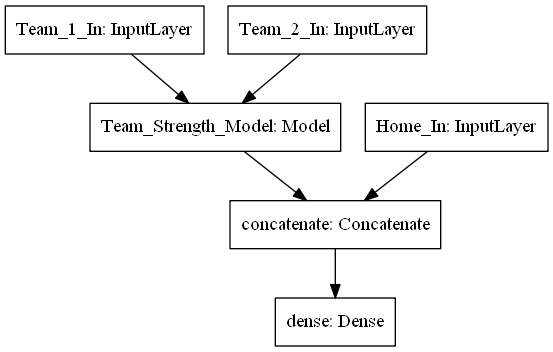

In [11]:
plot_model(model)

# Stacking models

## Add the model predictions to the tournament data

In [12]:
games_tourney['pred'] = model.predict([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']])

In [13]:
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
0,1985,288,73,0,-3,-9,41,50,0,-3.713293
1,1985,5929,73,0,4,6,61,55,1,1.711708
2,1985,9884,73,0,5,-4,59,63,0,-0.422603
3,1985,73,288,0,3,9,50,41,1,1.416811
4,1985,3920,410,0,1,-9,54,63,0,3.223604


## Create an input layer with multiple columns

In [14]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer=Adam(0.1), loss='mean_absolute_error')

In [15]:
X_gt = games_tourney[['home', 'seed_diff', 'pred']].to_numpy('float32')
y_gt = games_tourney['score_diff'].to_numpy('float32')

X_gt_tr, X_gt_tt, y_gt_tr, y_gt_tt = train_test_split(X_gt, y_gt,
                                                      train_size=3168,
                                                      random_state=42)

In [16]:
model.fit(X_gt_tr, y_gt_tr,
          epochs=5,
          verbose=1)

Train on 3168 samples
Epoch 1/5
3168/3168 [==============================] - 1s 291us/sample - loss: 8.9392
Epoch 2/5
3168/3168 [==============================] - 0s 99us/sample - loss: 8.9043
Epoch 3/5
3168/3168 [==============================] - 0s 102us/sample - loss: 8.8931
Epoch 4/5
3168/3168 [==============================] - 0s 101us/sample - loss: 8.9468
Epoch 5/5
3168/3168 [==============================] - 0s 102us/sample - loss: 8.8614


## Evaluate the model

In [17]:
print(model.evaluate(X_gt_tt, y_gt_tt, verbose=0))

8.831568281377681


In [18]:
games_tourney.to_csv('gt_with_preds.csv')